# MNIST - algorithm explainability

In [1]:
# The following two cells improve the formatting of the notebook

In [2]:
# Increase notebook cell width. Cell below increases the height.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

## General libraries

In [4]:
#Libraries
import lime
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline

## Helper functions

In [5]:
def plot_distribution(df, chart_title="Enter title"):
#     fig, ax = plt.subplots(figsize=(4, 3))
    plt.bar(left=df["label"].value_counts().index,
           height=df["label"].value_counts().values,
          alpha=0.6,
          align="center",
          width=0.5)
    plt.title("Distribution of labels\nacross MNIST\n%s" % chart_title)
    plt.xlim(-1, 10)
    plt.xlabel("Labels")
    plt.ylabel("No. of examples")

## Raw data

In [6]:
%%bash
ls -l data/

total 151604
-rw-rw---- 1 root everybody  22176691 Aug  2 23:39 fashion-mnist_test.csv
-rw-rw---- 1 root everybody 133047193 Aug  2 23:40 fashion-mnist_train.csv


In [7]:
# Import train and test datasets
df_train = df_train = pd.read_csv("data/fashion-mnist_train.csv")
df_test = pd.read_csv("data/fashion-mnist_test.csv")

In [8]:
print("df_train.shape:", df_train.shape)
print("df_test.shape:", df_test.shape)

df_train.shape: (60000, 785)
df_test.shape: (10000, 785)


### Train and test distributions

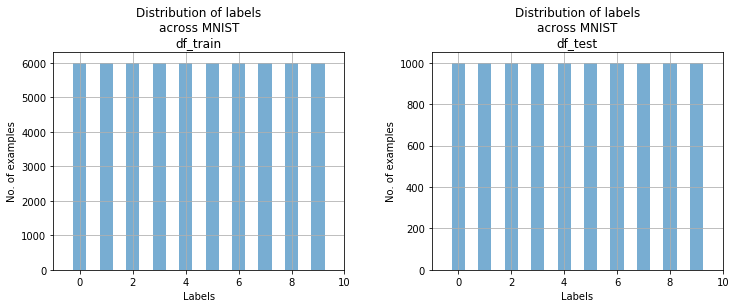

In [48]:
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_distribution(df_train, chart_title="df_train")
plt.grid()
plt.subplot(1, 2, 2)
plot_distribution(df_test, chart_title="df_test")
plt.grid()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.3, hspace=None)

## Data preprocessing

In [10]:
# Convert data to numpy arrays for modeling
X_train = df_train.iloc[:, 1:].as_matrix()
y_train = df_train["label"].as_matrix()
X_test = df_test.iloc[:, 1:].as_matrix()
y_test = df_test["label"].as_matrix()

## Pipelines

### Helper functions

In [80]:
# Function to execute all pipeline steps
def execute_pipeline(pipeline):
    pipeline.fit(X_train, y_train)
    prediction = pipeline.predict(X_test)
    mean_acc = pipeline.score(X_test, y_test)
    algo = list(pipeline.get_params().values())[1][1][0]
    preproc = list(pipeline.get_params().values())[1][0][0]
    return prediction, mean_acc, algo, preproc

In [81]:
# Function to create scatter plot of test results
def plot_test_results_scatter(results, pipeline_name="Enter pipeline name"):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(results[0], y_test,alpha=0.01, s=100)
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    ax.set_title("Pipeline name: %s\nAlgo: %s, Preprocessing: %s\nMean accuracy: %.2f%%" % (pipeline_name,
                                                                                            results[2],
                                                                                            results[3],
                                                                                            (results[1]*100)))
    ax.grid()

### Preprocessors

#### Scalers

In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [30]:
minmax = MinMaxScaler()

#### PCA analysis

In [31]:
pca = PCA()

In [32]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

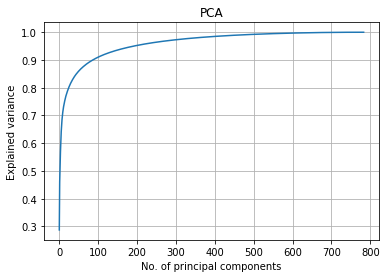

In [54]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(list(range(X_train.shape[1])), pca.explained_variance_ratio_.cumsum())
ax.set_xlabel("No. of principal components")
ax.set_ylabel("Explained variance")
ax.set_title("PCA")
ax.grid()

In [74]:
print("The first 100 pricipal components explain %.1f%% of the variance." % (sum(pca.explained_variance_ratio_[:100])*100))

The first 100 pricipal components explain 91.0% of the variance.


In [60]:
print("The first 200 pricipal components explain %.1f%% of the variance." % (sum(pca.explained_variance_ratio_[:200])*100))

The first 200 pricipal components explain 95.2% of the variance.


In [75]:
pca1 = PCA(n_components=200)
pca2 = PCA(n_components=100)

### Algorithms

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier # multi-layer perceptron
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

In [89]:
?DecisionTreeClassifier

In [90]:
clf_rf1 = RandomForestClassifier(n_estimators=10, random_state=42)
clf_rf2 = RandomForestClassifier(n_estimators=25, random_state=42)
clf_rf3 = RandomForestClassifier(n_estimators=100, random_state=42)
clf_svm1 = svm.SVC(random_state=42)
clf_mlp1 = MLPClassifier(solver="lbfgs", alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
clf_dt1 = DecisionTreeClassifier(random_state=42)

## Results

### Pipeline 1

In [17]:
# Construct pipeline
pipeline1 = Pipeline(memory=None,
                   steps=[("minmax", minmax),
                         ("clf_rf2", clf_rf2)])

In [18]:
# Execute pipeline
p1_results = execute_pipeline(pipeline1)

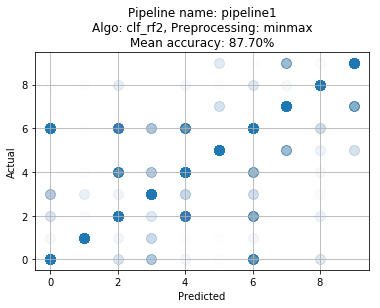

In [51]:
# Plot results
plot_test_results_scatter(p1_results, pipeline_name="pipeline1")

### Pipeline 2

In [23]:
# Construct pipeline
pipeline2 = Pipeline(memory=None,
                   steps=[("minmax", minmax),
                         ("clf_rf3", clf_rf3)])

In [24]:
# Execute pipeline
p2_results = execute_pipeline(pipeline2)

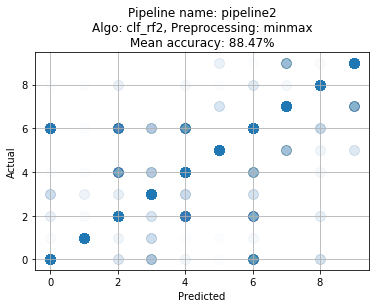

In [52]:
plot_test_results_scatter(p2_results, pipeline_name="pipeline2")

### Pipeline 3

In [65]:
# Construct pipeline
pipeline3 = Pipeline(memory=None,
                   steps=[("pca1", pca1),
                         ("clf_rf2", clf_rf2)])

In [66]:
# Execute pipeline
p3_results = execute_pipeline(pipeline3)

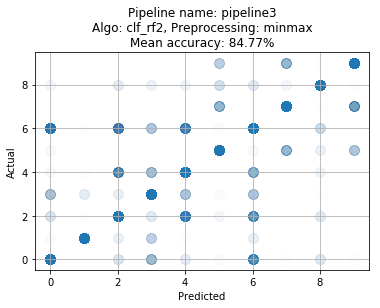

In [68]:
plot_test_results_scatter(p3_results, pipeline_name="pipeline3")

### Pipeline 4

In [69]:
# Construct pipeline
pipeline4 = Pipeline(memory=None,
                   steps=[("pca1", pca1),
                         ("clf_rf3", clf_rf3)])

In [70]:
# Execute pipeline
p4_results = execute_pipeline(pipeline4)

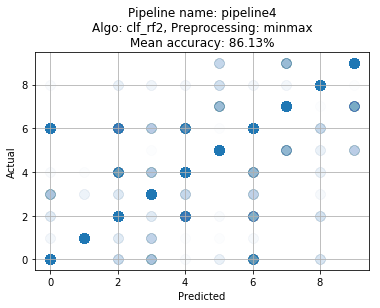

In [71]:
plot_test_results_scatter(p4_results, pipeline_name="pipeline4")

### Pipeline 5

In [77]:
# Construct pipeline
pipeline5 = Pipeline(memory=None,
                   steps=[("pca2", pca2),
                         ("clf_rf3", clf_rf3)])

In [78]:
# Execute pipeline
p5_results = execute_pipeline(pipeline5)

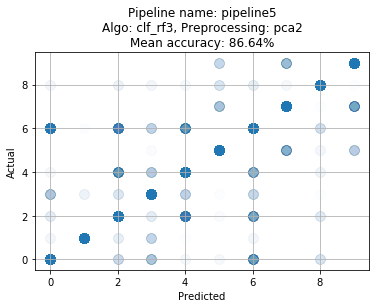

In [86]:
plot_test_results_scatter(p5_results, pipeline_name="pipeline5")

### Pipeline 6

In [84]:
# Construct pipeline
pipeline6 = Pipeline(memory=None,
                   steps=[("pca2", pca2),
                         ("clf_rf2", clf_rf2)])

In [85]:
# Execute pipeline
p6_results = execute_pipeline(pipeline6)

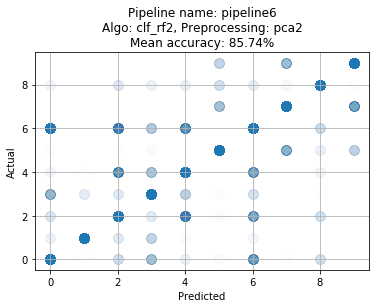

In [87]:
plot_test_results_scatter(p6_results, pipeline_name="pipeline6")

### Pipeline 7

In [91]:
# Construct pipeline
pipeline7 = Pipeline(memory=None,
                   steps=[("pca2", pca2),
                         ("clf_dt1", clf_dt1)])

In [92]:
# Execute pipeline
p7_results = execute_pipeline(pipeline7)

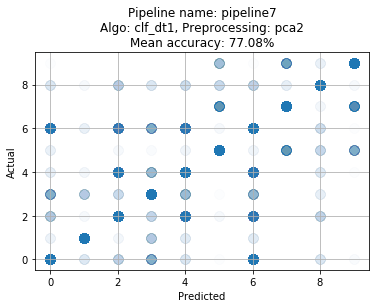

In [93]:
plot_test_results_scatter(p7_results, pipeline_name="pipeline7")